In [1]:
# essentials
import sys
import pandas as pd
import numpy as np
from importlib import reload
import pickle
from collections import defaultdict

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# access to files in drive
from google.colab import drive
drive.mount('/content/drive')
from tqdm import tqdm

Mounted at /content/drive


# Step 1: We install the packages

In [2]:
# GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4


Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.2 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 11.4 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 11.6 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 61.9 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 36.0 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 9.8 MB/s eta 0:00:00
    Creating /tmp/pip-build-env-a3y5xm2_/overlay/local/bin
    changing mode of /tmp/pip-build-env-a3y5xm2_/overlay/local/bin/ninja to 755
    changing mode of /tmp/pip-build-env-a3y5xm2_/overlay/

In [3]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin" # the model is in bin format

# Step 2: Import the libraries

In [4]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

# Step 3: Download the model

In [5]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

# Step 4: Loading the model


In [6]:
# GPU
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


# Step 5: Create a prompt template

Read drug side effect dataset

In [3]:
root_dir = 'drive/MyDrive/1. Research 2021/Kwaai AI for Life Sciences/'
queries = pd.read_excel(root_dir + "SET1_drug_side_effect_ten_randomized_associations.xlsx")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
temperatures = [0.0,0.5,1.0]

for i in tqdm(set(queries['drug name'])):
  result_llama = pd.DataFrame()
  df = queries[queries['drug name'] == i]
  drug_name = df.iloc[0]['drug name']
  for j in range(df.shape[0]):
    side_effect_name = df.iloc[j]['side effect']


    prompt = "Is " + side_effect_name  + " a side effect of the drug " + drug_name + ". Provide a YES or NO answer only."
    prompt_template=f'''SYSTEM: answer with YES or NOT without explanations. Be direct like a machine.

    USER: {prompt}

    ASSISTANT:
    '''

    for k in temperatures:
      response=lcpp_llm(prompt=prompt, max_tokens=20, temperature=0.5, top_p=0.95,
                      repeat_penalty=1.2, top_k=100,
                      echo=False)

      result_llama = result_llama.append({'drug': i, 'side effect': side_effect_name, 'temperature': k, 'Llama2_response':response["choices"][0]["text"], 'label': df.iloc[j]['label']}, ignore_index=True)

  result_llama.to_excel(root_dir + "results/"+drug_name +"_Llama-2-13B-chat-GGML.xlsx")

Streaming output truncated to the last 5000 lines.
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-ma

# Read/process the results

In [4]:
results = pd.DataFrame()
for i in tqdm(set(queries['drug name'])):
  try:
    df = queries[queries['drug name'] == i]
    drug_name = df.iloc[0]['drug name']
    df2 = pd.read_excel(root_dir + "results/"+drug_name +"_Llama-2-13B-chat-GGML.xlsx")
    results = results.append(df2, ignore_index = True)
  except:
    continue

100%|██████████| 444/444 [01:29<00:00,  4.98it/s]


In [7]:
print(len(set(results['drug'])))

168


In [14]:
def calculate_acuracy(labels, prediction):
  tp = sum((labels > 0) & (prediction > 0))
  tn =  sum((labels == 0) & (prediction == 0))
  P = sum(labels > 0)
  N = sum(labels == 0)

  return (tp + tn) / float(P + N)

In [27]:
accuracy_per_drug = pd.DataFrame()
for i in tqdm(set(results['drug'])):
  for j in set(results['temperature']):
    df = results[(results['drug'] == i) & (results['temperature'] == j)]
    labels = list()
    for k in range(df.shape[0]):
      try:
        if 'no' in df.iloc[k]['Llama2_response'].lower():
          labels.append(0)
        elif 'yes' in df.iloc[k]['Llama2_response'].lower():
          labels.append(1)
        else:
          labels.append(0)
      except:
        labels.append(0)

    acc = calculate_acuracy(np.array(labels), np.array(list(df['label'])))
    accuracy_per_drug = accuracy_per_drug.append({'drug': list(df['drug'])[0], 'accuracy': acc, 'temperature': j }, ignore_index = True)


100%|██████████| 168/168 [00:02<00:00, 61.58it/s]


<Axes: xlabel='temperature', ylabel='accuracy'>

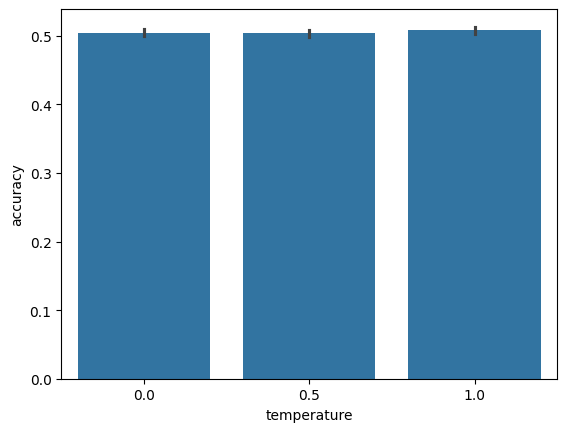

In [31]:
sns.barplot(data=accuracy_per_drug, x = 'temperature', y = 'accuracy')